# [NTDS'19] tutorial 7: PyGSP
[ntds'19]: https://github.com/mdeff/ntds_2019

adapted from [NTDS'17](https://nbviewer.jupyter.org/github/mdeff/ntds_2017/blob/outputs/demos/08_pygsp.ipynb) (by [Michaël Defferrard](https://deff.ch), [EPFL LTS2](https://lts2.epfl.ch))

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch)

This is a tutorial on [PyGSP](https://github.com/epfl-lts2/pygsp), a Python package to ease signal processing on graphs.
The PyGSP facilitates a wide variety of operations on graphs, like computing their Fourier basis, filtering or interpolating signals, plotting graphs, signals, and filters. The package includes a wide range of graphs and many filter banks. Despite all the pre-defined models, you can easily use a custom graph by defining its adjacency matrix, and a custom filter bank by defining a set of functions in the spectral domain.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from pygsp import graphs, filters

## 1. Graph creation, models, properties, visualization

Graphs are created with the [graphs module](https://pygsp.readthedocs.io/en/stable/reference/graphs.html). It includes a wide range of graphs:
* readily built on a manifold such as;  

`graphs.grid2d()`, `graphs.Bunny()`, `graphs.Swissroll()` etc.  
* models for generating random graphs such as;

`graphs.ErdosRenyi()`, `graphs.BarabasiAlbert()`, `graphs.Sensor()`, `graphs.StochasticBlockModel()` etc.

### 1.1 Constructing a feature graph

Graphs can also be constructed from a set of points in $\mathbb{R}^d$.

Let $\mathbf{X}$ be a data matrix $\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\intercal \in \mathbb{R}^{N \times d}$, where each $\mathbf{x} \in \mathbb{R}^d$ is a sample for which we have $d$ features.

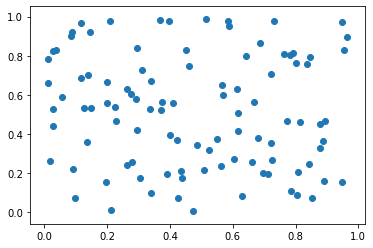

In [3]:
n_points = 100
dimensionality = 2
points = np.random.uniform(size=(n_points, dimensionality))
plt.scatter(points[:, 0], points[:, 1]);

**1. Determine the connectivity pattern:**
* kNN graph
* $\epsilon$ - radius graph

**2. Determine edge weights with a Gaussian Kernel** 
$$\mathbf{W}[i,j] = \exp(-\frac{||\mathbf{x}_i - \mathbf{x}_j||^2_2 }{ \sigma^2})$$ 

In [4]:
sigma = 0.1

In [5]:
G_NN = graphs.NNGraph(points, NNtype='knn', k=2, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G_NN.N} nodes, {G_NN.Ne} edges')

100 nodes, 129 edges


In [6]:
G_NN = graphs.NNGraph(points, NNtype='radius', epsilon=0.1, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G_NN.N} nodes, {G_NN.Ne} edges')

100 nodes, 133 edges


### 1.2 Graph from adjacency matrix

100 nodes, 194 edges
Connected: False
Directed: False


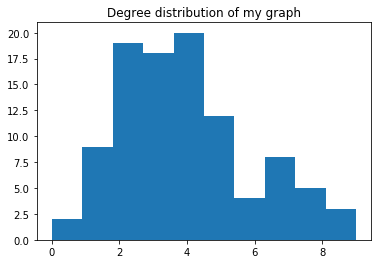

In [7]:
W = sparse.random(100, 100, 0.02)  # Sparse graph.
W.setdiag(0)
W = W + W.T

G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

print('Connected: {}'.format(G.is_connected()))
print('Directed: {}'.format(G.is_directed()))

plt.hist(G.d)
plt.title('Degree distribution of my graph');

### 1.3 Graph layout

To be able to plot a graph, we need to embed its nodes in a 2D or 3D space. The process to find coordinates for each nodes is called [layout](https://en.wikipedia.org/wiki/Graph_drawing). Most included graph models define these. If that's not the case, or if you create the graph from an adjacency matrix, [`pygsp.graphs.Graph.set_coordinates()`](https://pygsp.readthedocs.io/en/stable/reference/graphs.html#pygsp.graphs.Graph.set_coordinates) can be used to set it.

In our previous example, the nodes had a natural 2D embedding. Hence, it is automatically plotted using the 2D coordinates enclosed in `points` and the selected nearest neighborhood connectivity:

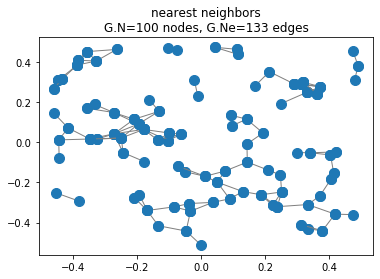

In [8]:
G_NN.plot()

Nevertheless, to plot the latter graph, we need to set a layout. We can visualize the network within different layouts:

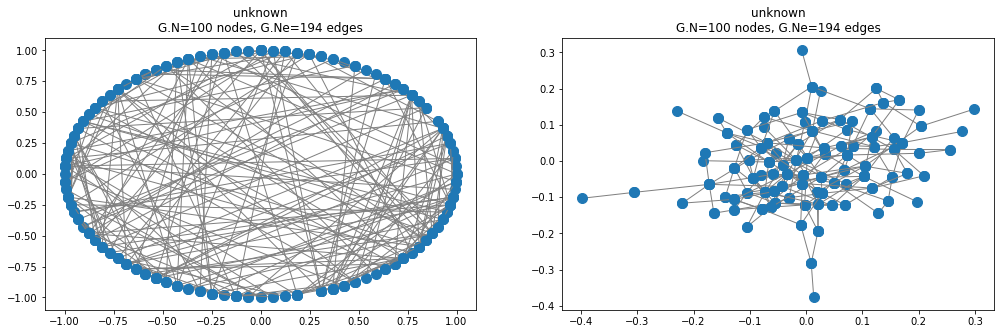

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

G.set_coordinates('ring2D')
G.plot(ax=axes[0])

G.set_coordinates('spring')
G.plot(ax=axes[1])

## 2. Spectral graph theory: graph spectrum, Laplacian eigenmaps

Let us create a random community graph using the stochastic block model and perform its spectral analysis:

In [10]:
G = graphs.StochasticBlockModel(N=200, k=3, p=0.1, q=0.002)

We can plot the sparsity pattern and the connectivity to visualize the communities:

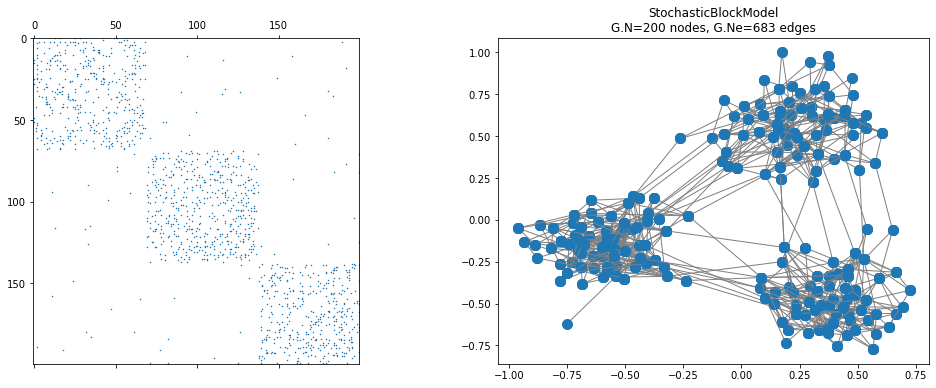

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].spy(G.W, markersize=0.5)
G.set_coordinates(kind='spring')
G.plot(ax=axes[1])

Spectral analysis of a graph begins with the eigenvalue decompostion of the graph Laplacian. First we need to compute Laplacian matrix:

In [12]:
G.compute_laplacian('combinatorial') 
G.L

<200x200 sparse matrix of type '<class 'numpy.float64'>'
	with 1566 stored elements in Compressed Sparse Column format>

Or we can use the normalized Laplacian by calling `G.compute_laplacian('normalized')`.

### 2.1 Spectrum of a graph

Let's look at the first few eigenvalues. Recall that for sparse matrices, we may use the optimized eigensolvers from the `sparse` module from `scipy` to obtain the first few eigenvalues and eigenvectors, such as:

In [13]:
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')

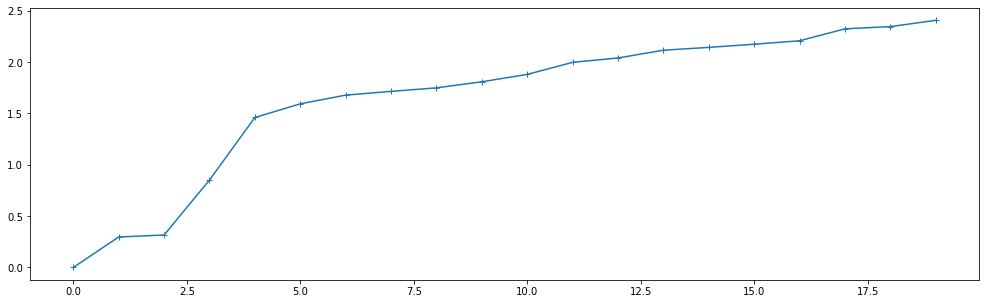

In [14]:
plt.figure(figsize=(17, 5))
plt.plot(eig_val, '+-');

**Question:** How many connected components exist in your random network according to the graph spectrum?

### 2.2 Eigenmaps

Let us visualize the first 4 eigenvectors as a signal on the graph using `graphs.plot_signal()` command:

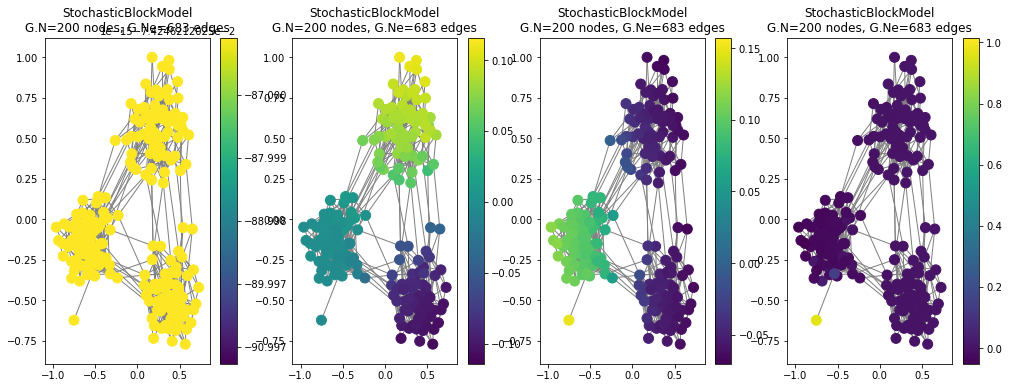

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(17, 6))
G.plot_signal(U[:, 0], ax=axes[0])
G.plot_signal(U[:, 1], ax=axes[1])
G.plot_signal(U[:, 2], ax=axes[2])
G.plot_signal(U[:, 3], ax=axes[3])

Let us also visualize the datapoints on a lower dimensional embedding given by the eigenmap of the Laplacian. The first eigenvector's information is useless (as long as we use the combinatorial Laplacian anyways) as it is constant. So, we can plot each node $i$ in 2D with coordinates $(u_2(i), u_3(i))$:

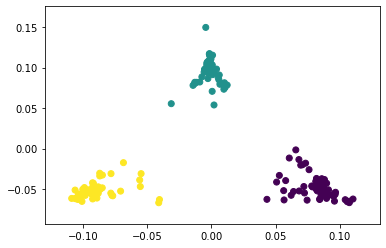

In [16]:
plt.scatter(U[:, 1], U[:, 2], c=G.info['node_com'])

**Exercise**: Plot first few eigenvectors of a ring graph as a function of its eigenvalues. What do you observe?

* Use `G = graphs.Ring(N=50)`

### 2.3 Exercise: Spectral Clustering

* Show that, in the last example, performing $k$-means in the $2D$ plane recovers the 3 communities!

## 3. Graph Signal and Graph Fourier Transform

Let's generate a random signal on our graph and plot it on the graph.

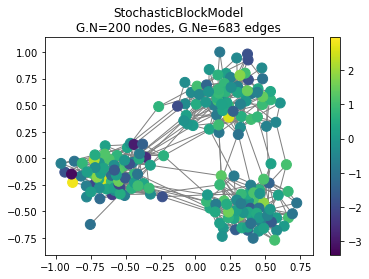

In [17]:
signal = np.random.normal(size=G.N)
G.plot_signal(signal)

### 3.1 Gradient and divergence

The gradient $\nabla_\mathcal{G} \ f$ of the signal $f$ on the graph $\mathcal{G}$ is a signal on the edges defined as

$$(\nabla_\mathcal{G})_{(i,j)} \ f = \sqrt{W_{ij}} (f_j - f_i)$$

We may easily obtain it by calling `graphs.compute_differential_operator()` command as follows;

In [18]:
G.compute_differential_operator()
gradient = G.D @ signal
assert gradient.size == G.Ne

Similarly, we can compute the divergence of an edge signal, which is again a signal on the nodes.

$$(\operatorname{div}_\mathcal{G} x)_i = \sum_{j \sim i} \sqrt{W_{ji}} x_{(j,i)} - \sum_{i \sim j} \sqrt{W_{ij}} x_{(i,j)}$$

In [19]:
divergence = G.D.T @ gradient
assert divergence.size == G.N

The Laplacian operator is the divergence of the gradient by definition. Let us check if we obtain the same output signal by taking the Laplacian of the signal we generated;

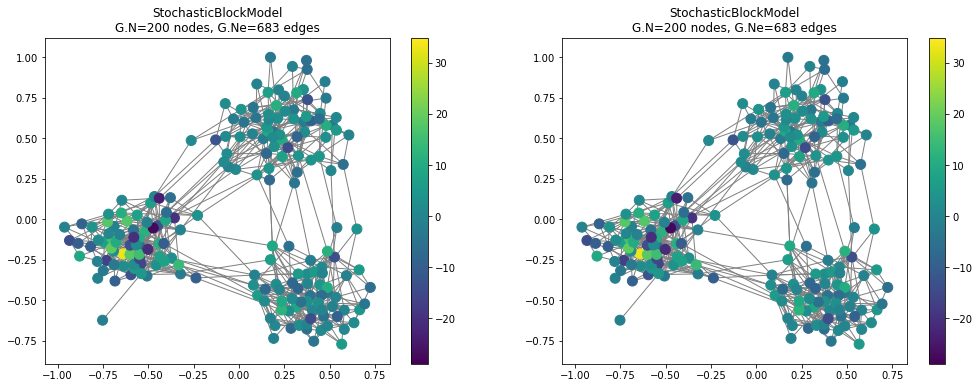

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(17, 6))
G.plot_signal(divergence, ax=axes[0])
G.plot_signal(G.L @ signal, ax=axes[1])

### 3.2 Smoothness

The smoothness of a signal can be computed by the quadratic form

$$ f^\intercal L f = \| \nabla_\mathcal{G} f \|_2^2 = \sum_{i \sim j} W_{ij} (f_j - f_i)^2 $$

In [21]:
signal.T @ G.L @ signal / np.linalg.norm(signal)**2

6.845501475598761

Let's compare it with the partitioning function:
$$ x[i] =
\begin{cases}
    -1 &\text{if } i \in S_1, \\
    0  &\text{if } i \in S_2, \\
    1  &\text{if } i \in S_3,
\end{cases}
$$
where $S_i$ is the set of nodes in partition $i$.

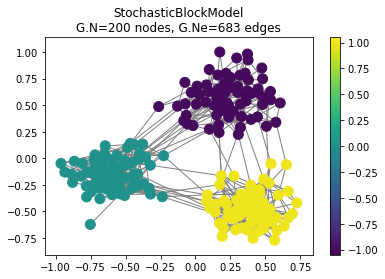

In [22]:
x = G.info['node_com'] - 1
G.plot_signal(x)

In [23]:
x.T @ G.L @ x / np.linalg.norm(x)**2

0.4351145038167939

That function is certainly smoother!

### 3.3 Graph Fourier transform

We can analyze the spectral content of a graph signal through the graph Fourier transform. It indicates how the signal variates on the connectivity pattern of the graph, i.e.; low-pass, band-pass, or high-pass.

We simply call `graphs.compute_fourier_basis()` command to compute the Fourier basis of a graph;

In [24]:
G.compute_fourier_basis()

We can also asses the smoothness of the signals we have generated above by plotting their Fourier transform on the graph spectrum;

Text(0.5, 0, 'graph spectrum')

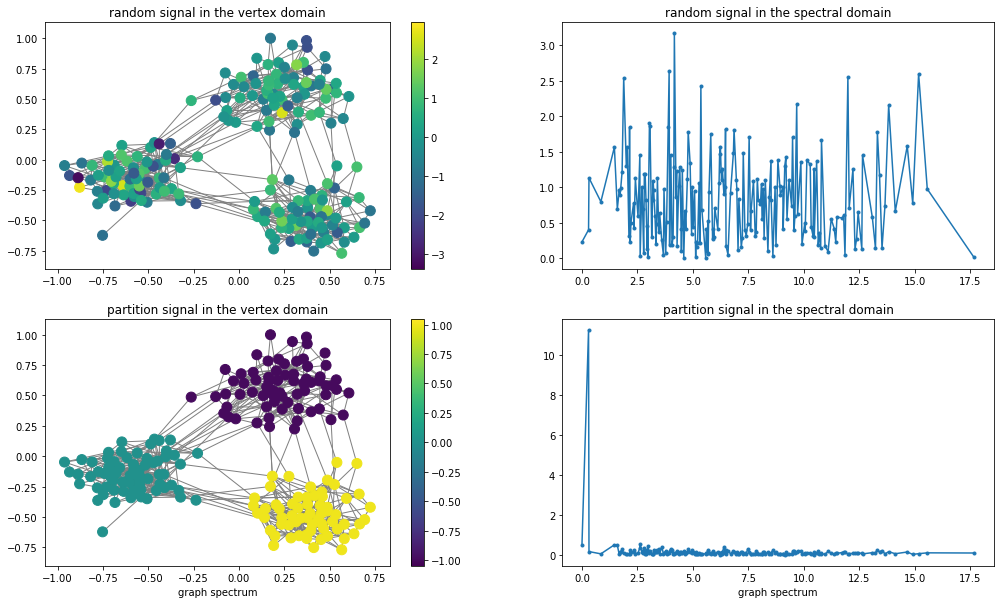

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

signal_hat = G.gft(signal)  # Fourier transform of the random signal
x_hat = G.gft(x)  # Fourier transform of the partition signal

G.plot_signal(signal, ax=axes[0, 0])
G.plot_signal(x, ax=axes[1, 0])

axes[0, 1].plot(G.e, np.abs(signal_hat), '.-')
axes[1, 1].plot(G.e, np.abs(x_hat), '.-')


axes[0, 0].set_title('random signal in the vertex domain')
axes[1, 0].set_title('partition signal in the vertex domain')
axes[0, 1].set_title('random signal in the spectral domain')
axes[1, 1].set_title('partition signal in the spectral domain')
axes[1, 0].set_xlabel("graph spectrum")
axes[1, 1].set_xlabel("graph spectrum")

## 4. Graph Signal Filtering

A graph signal $\mathbf{x}$ is filtered as
$$\mathbf{y} = \mathbf{U} \hat{g}(\mathbf{\Lambda}) \mathbf{U}^\intercal \, \mathbf{x} = \hat{g}(\mathbf{U} \mathbf{\Lambda} \mathbf{U}^\intercal) \, \mathbf{x} = \hat{g}(\mathbf{L}) \, \mathbf{x},$$

where $\hat{g}(\cdot)$ is the filter kernel defined in the specral domain as a function of the eigenvalues ("frequencies"). We can further separate the filtering operation into the following steps:

1. We obtain the spectral domain representation of the signal by GFT: 
$\hat{\mathbf{x}} = \mathbf{U}^\intercal \, \mathbf{x}$.
2. We filter the signal on the spectral domain by multiplicating each Fourrier coeeficient with the corresponding filter coeffcient, i.e.; elementwise multiplication: $\hat{\mathbf{y}} = \hat{g} \odot \hat{\mathbf{x}} = \hat{g}(\mathbf{\Lambda})\hat{\mathbf{x}} $
3. We return back to the vertex domain by taking the IGFT of the filtered signal: $\mathbf{y} = \mathbf{U}\hat{\mathbf{y}}$



You can also consider the filtering operation as a matrix vector multiplication between the filtering operator, $\hat{g}(\mathbf{L})$, and the graph signal $\mathbf{x}$.



The [`filters`](https://pygsp.readthedocs.io/en/stable/reference/filters.html) module on PyGSP includes the implementation of commonly used graph filters. 

### 4.1 Simple Filtering: heat diffusion

Let us accomplish a simple filtering operation using the heat kernel $h(\lambda)$ is defined as:
$$h_\tau(\lambda)=\exp^{-\tau\lambda}.$$

We may visualize the heat diffussion on a manifold graph by generating a filter bank of heat kernels with different $\tau$ parameters:

In [26]:
G = graphs.Bunny()  # Stanford bunny manifold graph.
G.compute_fourier_basis()  # Construct the Fourrier basis of the graph.
taus = [5, 20, 100]

Let’s create a signal as a Kronecker delta located on one vertex, e.g. the vertex 20. That signal is our heat source.

In [27]:
s = np.zeros(G.N)
DELTA = 20
s[DELTA] = 1

We can call `filters.filter()` function to realize the filtering operation:

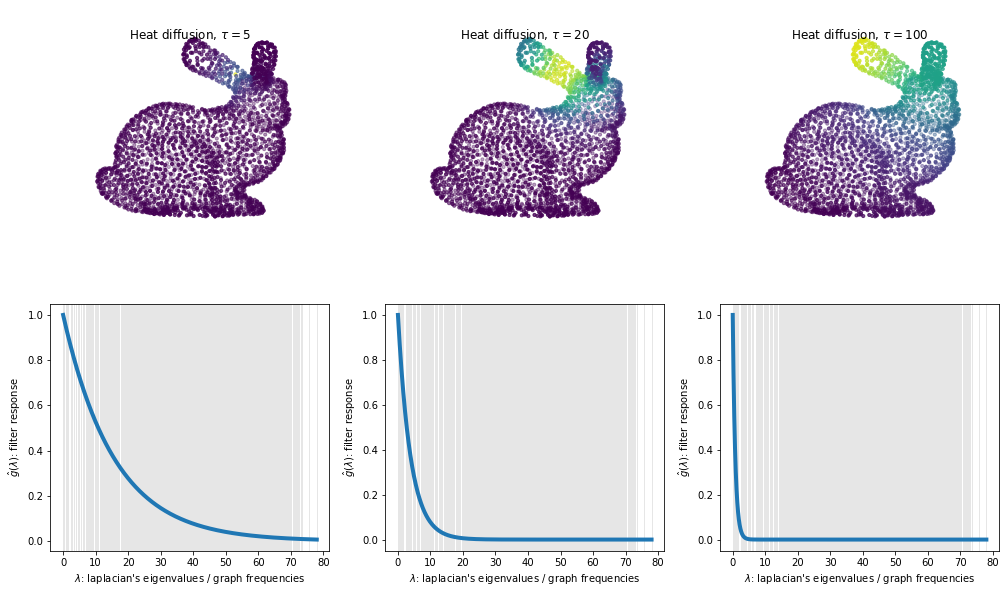

In [28]:
fig = plt.figure(figsize=(17, 10))

for i in range(len(taus)):
    g = filters.Heat(G, taus[i])  # kernel constructed specifically on the spectrum of graph G
    s_out = g.filter(s, method='chebyshev')
    ax = fig.add_subplot(2, len(taus), i+1, projection='3d')
    G.plot_signal(s_out, colorbar=False, ax=ax)
    title = r'Heat diffusion, $\tau={}$'.format(taus[i])
    _ = ax.set_title(title)
    ax.set_axis_off()
    ax = fig.add_subplot(2, len(taus), i+4)
    g.plot(ax=ax)
#fig.tight_layout()

**Localization**: We can also localize a kernel on a particular part of our manifold graph using `filtes.localize()` command as follows:

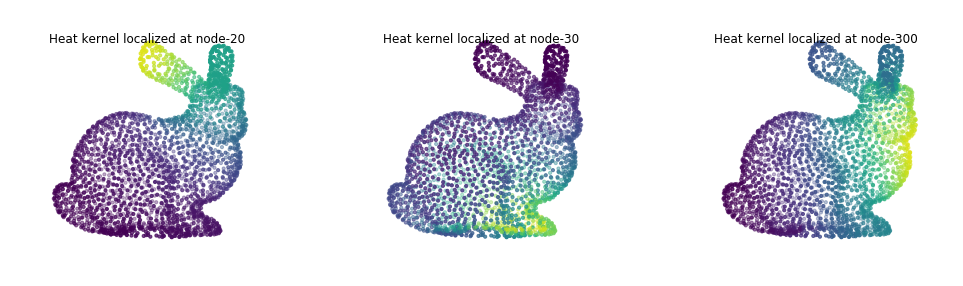

In [29]:
fig = plt.figure(figsize=(17, 5))

g = filters.Heat(G, tau = 100)  # The heat kernel to be localized
DELTA = [20, 30, 300]  # node to localize the heat kernel

for i in range(len(DELTA)):
    s_localized = g.localize(DELTA[i])
    ax = fig.add_subplot(1, len(DELTA), i+1, projection='3d')
    G.plot_signal(s_localized, colorbar=False, ax=ax)
    title = r'Heat kernel localized at node-{}'.format(DELTA[i])
    _ = ax.set_title(title)
    ax.set_axis_off()
#fig.tight_layout()

### 4.2 Example of denoising using Tikhonov regularization

Let's define a low-pass filter
$$ g(\lambda) = \frac{1}{1+\tau\lambda} $$

Given a noisy version of a smooth signal $x_\text{noisy}$, one can denoise it with the low-pass filter $g$:
$$ x_\text{denoised} = \mathbf{U}g(\mathbf{\Lambda})\mathbf{U}^\top x_{\text{noisy}}, $$
which corresponds to the filtering operator: $g(L)  = (I + \tau L)^{-1}$

We can set a custom filter using by defining a kernel function and calling the command `filters.Filter()`:

In [30]:
tau = 1
def g(x):
    return 1. / (1. + tau * x)
g = filters.Filter(G, g)

In [31]:
x = s_localized
# add some noise
x_noisy = x +  np.sqrt(np.var(x)/3) * np.random.randn(G.N)

# the denoised signal:
x_denoised = g.filter(x_noisy, method='exact')

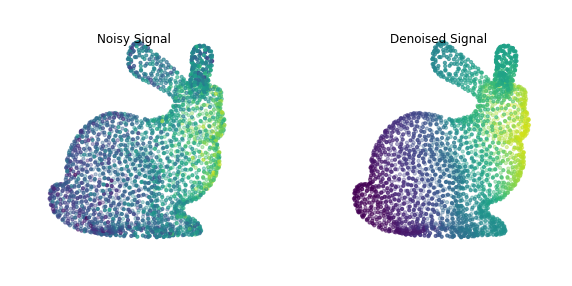

In [32]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
G.plot_signal(x_noisy, colorbar=False, ax=ax)
ax.set_title('Noisy Signal')
ax.set_axis_off()
ax = fig.add_subplot(1, 2, 2, projection='3d')
G.plot_signal(x_denoised, colorbar=False, ax=ax)
ax.set_title('Denoised Signal')
ax.set_axis_off()

### 4.3 Wavelet Decomposition of a Signal

Let’s now create a filter bank using one of the predefined filters, such as `filters.MexicanHat` to design a set of [Mexican hat wavelets](https://en.wikipedia.org/wiki/Mexican_hat_wavelet).

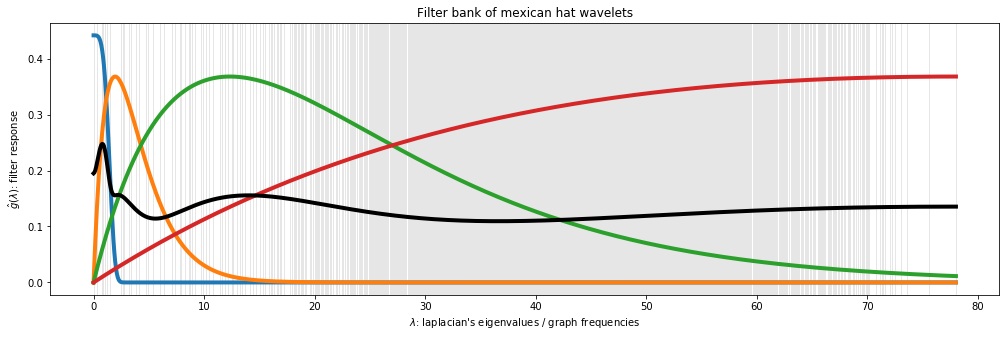

In [33]:
g = filters.MexicanHat(G, Nf=4)

fig, ax = plt.subplots(1, 1, figsize=(17, 5))
g.plot(ax=ax)
plt.title('Filter bank of mexican hat wavelets');

We can decompose a graph signal to the wavelet componenets by calling the `analyze()` method of a filter object. Then, we may try to recover our signal by using only those wavelet coefficients by calling `synthesize()` method.

In [34]:
s1 = x  # original signal
s2 = g.analyze(s1)  # wavelet coefficients
s3 = g.synthesize(s2)  # reconstructed signal

In [35]:
s2.shape

(2503, 4)

Let us see the reconstruction error given the wavelet representation above.

Reconstruction error: 0.94412


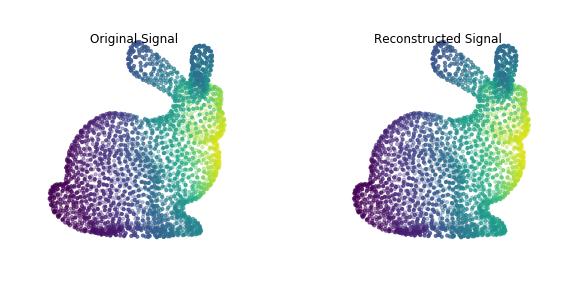

In [36]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
G.plot_signal(s1, colorbar=False, ax=ax)
ax.set_title('Original Signal')
ax.set_axis_off()
ax = fig.add_subplot(1, 2, 2, projection='3d')
G.plot_signal(s3, colorbar=False, ax=ax)
ax.set_title('Reconstructed Signal')
ax.set_axis_off()
print('Reconstruction error: {:.5f}'.format(np.linalg.norm(s1 - s3)))

**Exercise:** Try to do the wavelet decomposition using `filters.Itersine` with `Nf=4` filters and then synthesize the signal back. How do you explain the difference in reconstruction error between `Itersine` and `MexicanHat` representations? Hint: You may check the frequency response of `Itersine`.